# Template

In [12]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from PIL import Image
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter

plt.style.use('science')
plt.rcParams.update({'font.size': 14})

# Versuch 1

In [4]:
TABLE = [
    [2.00, 4.00, 8.00,  16.00, 32.0, 64.0,  128.0],
    [2.24, 4.49, 8.98,  17.95, 36.0, 71.8,  144.0], 
    [2.52, 5.04, 10.10, 20.16, 40.3, 80.6,  161.0],
    [2.83, 5.66, 11.30, 22.62, 45.3, 90.5,  181.0],
    [3.17, 6.35, 12.70, 25.39, 50.8, 102.0, 203.0],
    [3.56, 7.13, 14.30, 28.50, 57.0, 114.0, 228.0]
]

def get_xmin_from_table(group_num: int, element_num: int) -> tuple[float, float, float]:
    """
    Ermittelt das minimale Auflösungsvermögen (x_min) für ein spezifisches Element 
    des „Testobjekt 1951 USAF Target“ anhand der angegebenen Gruppen- und Elementnummer.

    Die Funktion durchsucht die tabellierten Raumfrequenzen des USAF-Targets, berechnet 
    daraus das Auflösungsvermögen als Kehrwert und gibt zusätzlich eine Unsicherheitsspanne 
    zurück, die sich aus den benachbarten Elementen (element_num ± 1) ableitet. Befindet 
    sich das angefragte Element am Rand der Tabelle, werden definierte Ersatzwerte 
    für die Unsicherheitsgrenzen verwendet.

    Parameter
    ----------
    group_num : int
        Gruppennummer des USAF-Targets (1–7).
    element_num : int
        Elementnummer innerhalb der Gruppe (1–6).

    Rückgabe
    --------
    tuple[float, float, float]
        Ein Tupel bestehend aus:
        - x_mid: Dem berechneten Auflösungsvermögen des gewählten Elements.
        - (x_pre, x_post): Untere und obere Unsicherheitsgrenze basierend auf den 
          benachbarten Elementen.

    Ausnahmen
    ---------
    ValueError
        Wird ausgelöst, wenn group_num nicht in [1, 7] oder element_num nicht in [1, 6] liegt.
    """
    if not (1 <= element_num <= 6):
        raise ValueError("element_num must be 1-6")
    if not (1 <= group_num <= 7):
        raise ValueError("group_num must be 1-7")

    arr = np.ravel(np.transpose(TABLE))   
    flat_index = (group_num - 1) * len(TABLE) + (element_num - 1)

    x_mid = 1/arr[flat_index]
    if flat_index <= 0:
        x_pre = 1/1.78
    else:
        x_pre = 1/arr[flat_index-1]
    
    if flat_index >= len(arr):
        x_post = 1/250
    else:
        x_post = 1/arr[flat_index+1]
    
    return x_mid, (x_pre, x_post)

In [4]:
d_1 = 2 #mm
d_2 = 3 #mm
d_3 = 6 #mm
dd = 0.1 #mm

f = 60 #mm
lam_blau = 470 #nm
lam_rot = 635 #nm
dlam = 5 #nm

wavelengths = [lam_blau, lam_rot]
diameters = [d_3, d_2, d_1]

data = list(itertools.product(wavelengths, diameters))

def deltx_min(lam, d, dlam=dlam, dd=dd, f=f):
    xmin = 0.61*2*f*lam / d
    dximn = xmin*(dlam/lam + dd/d)

    return xmin, dximn

In [5]:
Measurements = {
    'blau 6mm' : (7,2),
    'blau 3mm' : (6,3),
    'blau 2mm' : (5,6),
    'rot 6mm' : (6,6),
    'rot 3mm' : (5,6),
    'rot 2mm' : (5,3)
}

x_mess = []
dx_mess = []
print('Gemessene Werte')
for name, measure in Measurements.items():
    x_min, (low_x, high_x) = get_xmin_from_table(*measure)
    dx_min = max(low_x-x_min, x_min-high_x)

    print(f'{name}: x_min = {x_min*1000:.1f} pm {dx_min*1000:.2f} um')
    x_mess.append(x_min*1000)
    dx_mess.append(dx_min*1000)

x_theo = []
dx_theo = []
print('\nTheoretische Werte')
for i, (lam, d) in enumerate(data):
    x_min_theo , dx_min_theo = deltx_min(lam, d)
    print(f'{list(Measurements.keys())[i]}: x_min = {x_min_theo/1000:.2f} pm {dx_min_theo/1000:.2f} um')
    x_theo.append(x_min_theo/1000)
    dx_theo.append(dx_min_theo/1000)

Gemessene Werte
blau 6mm: x_min = 6.9 pm 0.87 um
blau 3mm: x_min = 12.4 pm 1.52 um
blau 2mm: x_min = 17.5 pm 2.14 um
rot 6mm: x_min = 8.8 pm 1.03 um
rot 3mm: x_min = 17.5 pm 2.14 um
rot 2mm: x_min = 24.8 pm 2.96 um

Theoretische Werte
blau 6mm: x_min = 5.73 pm 0.16 um
blau 3mm: x_min = 11.47 pm 0.50 um
blau 2mm: x_min = 17.20 pm 1.04 um
rot 6mm: x_min = 7.75 pm 0.19 um
rot 3mm: x_min = 15.49 pm 0.64 um
rot 2mm: x_min = 23.24 pm 1.35 um


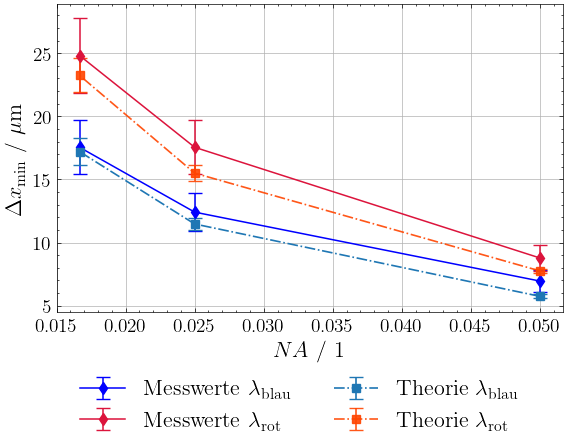

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))

NA = np.array(diameters) / (2 * f)
dNA = dd / (2*f)

# Messwerte übersichtshalber ohne Unsicherheit!
ax.errorbar(NA, x_mess[:3], yerr=dx_mess[:3], color='blue', fmt="-d", label=r"Messwerte $\lambda_\text{blau}$", capsize=5,linewidth=1.1)
ax.errorbar(NA, x_mess[3:], yerr=dx_mess[3:], color='crimson', fmt="-d", label=r"Messwerte $\lambda_\text{rot}$", capsize=5, linewidth=1.1)

ax.errorbar(NA, x_theo[:3], yerr=dx_theo[:3], color='tab:blue', fmt="-.s", label=r"Theorie $\lambda_\text{blau}$", capsize=5, linewidth=1.2)
ax.errorbar(NA, x_theo[3:], yerr=dx_theo[3:], color='orangered', alpha=0.9, fmt="-.s", label=r"Theorie $\lambda_\text{rot}$", capsize=5,linewidth=1.2)


ax.set_xlabel(r"$NA$ / 1", fontsize=16)
ax.set_ylabel(r"$\Delta x_\text{min}$ / $\mu$m", fontsize=16)
ax.grid(True)
fig.legend(loc="lower center", fontsize=16, frameon=False,ncols=2, bbox_to_anchor=(0.525, -0.17))
plt.tight_layout()
plt.show()

# Versuch 3

In [5]:
def print_from_table(group, element):
    x_min, (low_x, high_x) = get_xmin_from_table(group, element)
    dx_min = max(low_x-x_min, x_min-high_x)
    print(f'x_min = {x_min*1000:.2f} pm {dx_min*1000:.2f} um')
    return x_min*1000, dx_min*1000


def get_dist(array:list[int])->list[int]:
    """array must be sorted in ascending order!"""
    dist = []
    for i in range(len(array)-1):
        dist.append(array[i+1]-array[i])
    return dist

def plot_image_with_measure_line(filepath, x_positions, y_position, xlim, ylim):
    plt.rcParams.update({'font.size': 18})
    """
    Stellt ein Bild dar und zeichnet eine horizontale rote Linie 
    bei y_position von min(x_positions) bis max(x_positions),
    zusätzlich vertikale Markierungen an jedem x-Wert.

    Parameters
    ----------
    filepath : string
        Pfad zum Bild.
    x_positions : list or array-like
        X-Positionen der Markierungspunkte.
    y_position : float or int
        Y-Position der horizontalen Linie.
    """
    image = plt.imread(filepath)
    left_x = np.array(x_positions[0])
    right_x = np.array(x_positions[1]) 

    fig, ax = plt.subplots(1,1, figsize=(8, 6))
    ax.imshow(image, cmap="viridis")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


    ax.plot([left_x.min(), left_x.max()], [y_position, y_position],
             color='red', linewidth=2)
    ax.plot([right_x.min(), right_x.max()], [y_position, y_position],
             color='red', linewidth=2)

    for x in left_x:
        ax.plot([x, x], [y_position - 15, y_position + 15],
                 color='red', linewidth=1.5)
    for x in right_x:
        ax.plot([x, x], [y_position - 15, y_position + 15],
                 color='red', linewidth=1.5)
    
    distances = get_dist(left_x)
    distances.extend(get_dist(right_x))
    
    dist_mean = np.mean(distances)
    dist_std = np.std(distances) / np.sqrt(len(distances))
    delta_dist_i = 1.08
    dist_error = np.sqrt(dist_std**2 + delta_dist_i**2)
    print(f'd = {dist_mean:.1f} pm {dist_error:.1f} pixel')
    return dist_mean, dist_error

x_min = 176.68 pm 21.73 um
x_min = 88.50 pm 10.51 um
x_min = 44.21 pm 5.39 um
d = 29.9 pm 1.1 pixel
d = 60.0 pm 1.1 pixel
d = 120.8 pm 1.4 pixel
Pixelgröße p = 1.6552878086004545 pm 0.2641550414011468 pixel/um
compare:
 d2 = 60.0 pm 1.130270370801213
 d2_theo = 59.69434628975265 pm 16.618573289122622

compare:
 d3 = 120.75 pm 1.445086502601142
 d3_theo = 119.49434628975267 pm 33.65036725909969



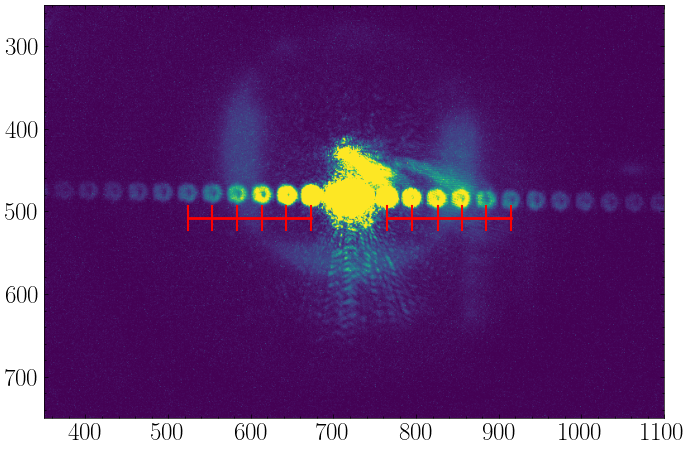

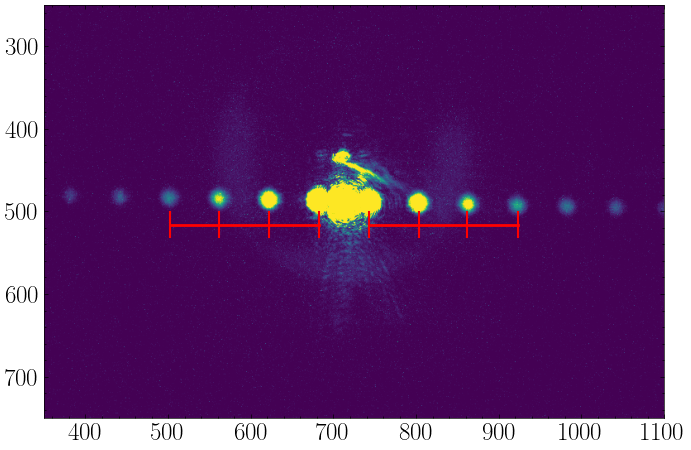

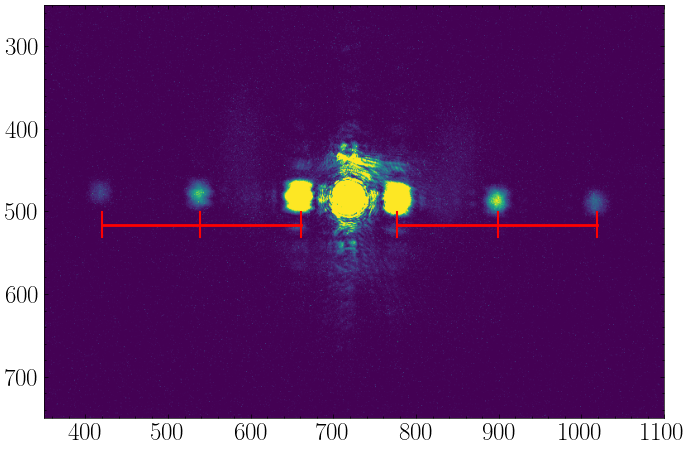

In [11]:

files = [
    'V03_Abstand_groß_Objekt_Beugung_2-4.png', #(2,4)
    'V02_Objekt_Beugung.png', #(3,4)
    'V03_Abstand_klein_Objekt_Beugung.png', #(4,4)
]
path = '/home/loki/Workspace/Labor/Experimentalphysik2/01_AbbeTheorie/data/'

a1, da1 = print_from_table(2,4)
a2, da2 = print_from_table(3,4)
a3, da3 = print_from_table(4,4)

image = plt.imread(path + files[0])
d1, dd1 = plot_image_with_measure_line(path+files[0], ([524, 553,583,613,643,673], [765, 795,826, 855, 885, 915]), 508, (350,1100), (750,250))
d2, dd2 = plot_image_with_measure_line(path+files[1], ([502, 561 ,622, 682], [743, 803, 862, 923]), 516, (350,1100), (750,250))
d3, dd3 = plot_image_with_measure_line(path+files[2], ([420, 538, 661], [777, 899, 1019]), 516, (350,1100), (750,250))

# Abstand der Intensitätsmaxima in Brennebene y
# y = f*tan(theta) ~= f*theta 

# Einzelspalt Minima bzw Maxiam gegeben durch
# a*sin(theta) = m * lambda 
# für Abstand von 2 MAxima folgt delta_theta = lambda / a

# somit: y = f*delta_theta = f*lambda / a
# Also messwerte Indirekt Proportional zu Spaltbreite a

# y gemessen in Pixeln impliziert d = p*f*lambda / a mit p pixelgröße

# aus erster gleichung berechne p:
f = 60e-3 #m
lam = 531.9e-9 #m
p = d1*a1 / (f*lam)
dp = p*(dd1/d1 + da1/a1)

# berechne d2 und d3 und verglecihe
d2_theo =  p*f*lam / a2
dd2_theo = d2_theo * (dp/p + da2/a2)
d3_theo =  p*f*lam / a3 
dd3_theo = d3_theo * (dp/p + da3/a3)

print(f'Pixelgröße p = {p*10e-12} pm {dp*10e-12} pixel/um')
print(f'compare:\n d2 = {d2} pm {dd2}\n d2_theo = {d2_theo} pm {dd2_theo}\n')
print(f'compare:\n d3 = {d3} pm {dd3}\n d3_theo = {d3_theo} pm {dd3_theo}\n')

# Versuch 4

In [19]:
def extract_intensity_profile(image_path):

    # Bild laden und in Graustufen konvertieren
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    height, width = img_array.shape
    y_start = height // 2 - 40
    y_end = height // 2 + 40

    # Mittelung über vertikalen Bereich
    profile = np.mean(img_array[y_start:y_end, :], axis=0)
    
    return profile

def plot_intensity_profile(profile, name):
    fig, ax = plt.subplots(figsize=(4.8,3.5))
    
    x = np.arange(len(profile))
    
    # Normierung auf Maximum
    profile_norm = profile / np.max(profile)
    
    ax.plot(x, profile_norm, linewidth=1.5, color='blue')
    ax.set_xlabel(r'$x$ / Pixel', fontsize=16)
    ax.set_ylabel(r'$\frac{I}{I_\text{max}}$ / 1', fontsize=16)
    ax.grid(True, alpha=1)
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig(f'/home/loki/Workspace/Labor/Experimentalphysik2/01_AbbeTheorie/results/V04{name}', dpi=300, bbox_inches='tight')
    plt.show()

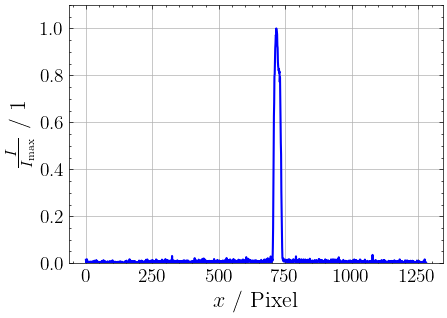

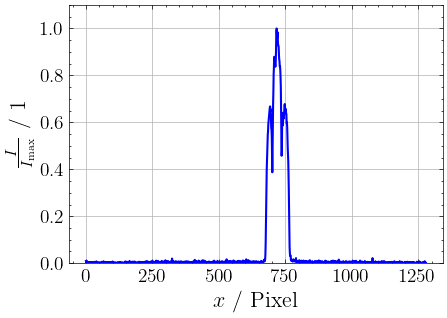

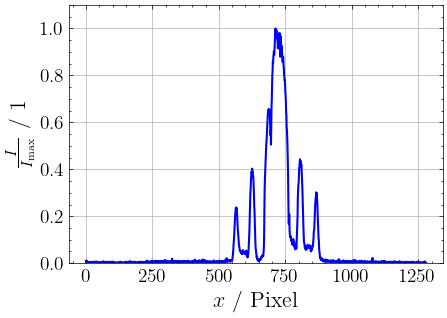

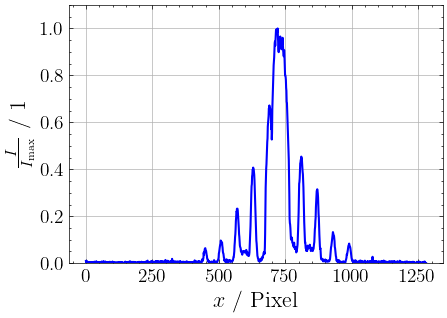

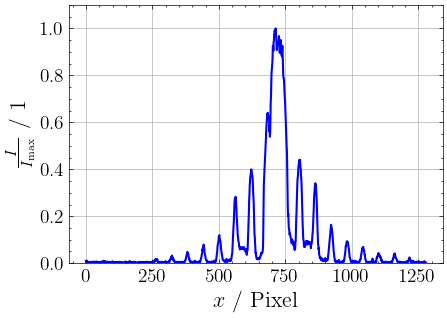

In [20]:
path = "/home/loki/Workspace/Labor/Experimentalphysik2/01_AbbeTheorie/data/"
files = {
    '0': 'V02_Objekt_Beugung_0.png',
    '1': 'V02_Objekt_Beugung_1.png',
    '3': 'V02_Objekt_Beugung_3.png',
    '5': 'V02_Objekt_Beugung_5.png',
    'alle': 'V02_Objekt_Beugung.png'
}

for name, filename in files.items():
    profile = extract_intensity_profile(path + filename)

    plot_intensity_profile(profile, files[name][3:-3])